# Multi-View DenseNet121 Training

This notebook demonstrates the training of a Multi-View DenseNet121 model for mammogram classification.

The notebook is organized as follows:
1. Setup and Imports
2. Configuration and Data Paths
3. Data Loading and Preprocessing
4. Model Creation and Training Setup
5. Training Loop
6. Memory Management

In [11]:
## Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import v2 as transforms
from torch.utils.data import DataLoader
import time
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score

In [12]:
## Import Model and Dataset
from MakeDataset_VinDr_classification_2 import MakeDataset_VinDr_classification_2
from models.densenet121 import create_model  # Imports from models/densenet121.py

In [13]:
## Devices
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Available GPUs: ", torch.cuda.device_count())
print("Current device ID: ", torch.cuda.current_device())

Available GPUs:  1
Current device ID:  0


In [14]:
## Configuration
extension = ".png"
target_size = 384  # DenseNet can work with different input sizes
batch_size = 8
learning_rate = 1e-4
epochs = 10
threshold = 0.5
weight_decay = 1e-3

In [15]:
## Data Paths
image_dir = "Dataset/"
label_dir_csv = "Dataset/remaining_full_path.csv"

In [16]:
from torch.utils.data import DataLoader, Subset
from collections import Counter
import numpy as np
import torchvision.transforms as transforms

# Define transforms - DenseNet expects normalized inputs
transform = transforms.Compose([
    transforms.Resize((target_size, target_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# ---- Step 1: Load the full dataset once ----
full_dataset = MakeDataset_VinDr_classification_2(
    image_dir=image_dir,
    label_csv=label_dir_csv,
    transform=transform,
    mode='all',          # you need to add this option in your dataset class
    split_size=0.0,      # no split here
    target_size=target_size
)

# ---- Step 2: Create 70/15/15 split ----
total_size = len(full_dataset.samples)
indices = np.random.permutation(total_size)

train_size = int(0.7 * total_size)
val_size   = int(0.15 * total_size)
test_size  = total_size - train_size - val_size

train_idx = indices[:train_size]
val_idx   = indices[train_size:train_size + val_size]
test_idx  = indices[train_size + val_size:]

# ---- Step 3: Balance only the training set ----
labels = [full_dataset.samples[i][2] for i in train_idx]
class_counts = Counter(labels)
min_class_count = min(class_counts.values())

balanced_train_idx = []
for cls in class_counts:
    cls_indices = [i for i, lbl in zip(train_idx, labels) if lbl == cls]
    balanced_train_idx.extend(np.random.choice(cls_indices, min_class_count, replace=False))

# ---- Step 4: Wrap subsets ----
train_dataset = Subset(full_dataset, balanced_train_idx)
val_dataset   = Subset(full_dataset, val_idx)
test_dataset  = Subset(full_dataset, test_idx)

# ---- Step 5: DataLoaders ----
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# ---- Step 6: Utility to check distribution ----
def get_label_distribution(subset, name="Dataset"):
    labels = [full_dataset.samples[i][2] for i in subset.indices]
    counter = Counter(labels)
    total = sum(counter.values())
    print(f"\n{name} Class Distribution:")
    for cls, count in counter.items():
        label_name = f"Class {cls} ({'Negative' if cls == 0 else 'Positive'})"
        print(f"  {label_name}: {count} samples ({(count / total) * 100:.2f}%)")
    print(f"  Total samples: {total}")

# ---- Step 7: Print distributions ----
get_label_distribution(train_dataset, "Train (Balanced)")
get_label_distribution(val_dataset, "Validation (Natural)")
get_label_distribution(test_dataset, "Test (Natural)")

print("\nDataset Sizes:")
print(f"  Training set size: {len(train_dataset)}")
print(f"  Validation set size: {len(val_dataset)}")
print(f"  Test set size: {len(test_dataset)}")



View distribution:
view_position
MLO    9773
CC     9693
Name: count, dtype: int64

Laterality distribution:
laterality
L    9741
R    9725
Name: count, dtype: int64
Initial count: 19466
After dropping NA: 19466
Unique study_ids: 4750
Final paired samples: 9499

Train (Balanced) Class Distribution:
  Class 1 (Positive): 2178 samples (50.00%)
  Class 0 (Negative): 2178 samples (50.00%)
  Total samples: 4356

Validation (Natural) Class Distribution:
  Class 0 (Negative): 932 samples (65.45%)
  Class 1 (Positive): 492 samples (34.55%)
  Total samples: 1424

Test (Natural) Class Distribution:
  Class 0 (Negative): 971 samples (68.09%)
  Class 1 (Positive): 455 samples (31.91%)
  Total samples: 1426

Dataset Sizes:
  Training set size: 4356
  Validation set size: 1424
  Test set size: 1426


In [17]:
## Create and Configure Model
model = create_model(num_classes=1, pretrained=True, drop_rate=0.2).to(device)

# Print model parameters
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters: ", pytorch_total_params // 10 ** 6, " mil")
print("Total number of trainable parameters: ", pytorch_total_trainable_params // 10 ** 6, " mil")

/home/intern04/miniconda3/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intern04/miniconda3/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total number of parameters:  16  mil
Total number of trainable parameters:  16  mil


In [18]:
## Training Utilities
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# Initialize optimizer, loss function, and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20)
criterion = nn.BCELoss()
early_stopper = EarlyStopper(patience=75, min_delta=0)
curr_best_val_acc = 0.0

In [19]:
## Training Loop
for epoch in range(1, epochs + 1):
    since = time.time()
    print('-' * 10)
    model.train()  # Set the model to training mode
    running_loss = 0.0
    print("#########Epoch: ", epoch)
    total = 0
    correct = 0
    
    # For computing metrics
    all_labels = []
    all_predictions = []

    # Training phase
    for i, data in enumerate(train_loader):
        inputs_cc, inputs_mlo, labels = data
        inputs_cc, inputs_mlo, labels = inputs_cc.float().to(device), inputs_mlo.float().to(device), labels.float().to(device)

        labels = labels.unsqueeze(1)
        predicted = model(inputs_cc, inputs_mlo)
        
        total_loss = criterion(predicted, labels)
        thresholded_preds = (predicted > threshold).float()
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
      
        running_loss += total_loss.item()
        total += labels.size(0)
        correct += (thresholded_preds == labels).sum().item()
        
        # Store predictions and labels for metrics computation
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(thresholded_preds.cpu().numpy())

    # Compute training metrics
    running_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_precision = precision_score(all_labels, all_predictions)
    train_recall = recall_score(all_labels, all_predictions)
    train_f1 = f1_score(all_labels, all_predictions)
    
    time_elapsed = time.time() - since
    curr_lr = optimizer.param_groups[0]["lr"]
    
    print(f"Epoch {epoch}")
    print(f"Training Metrics:")
    print(f"  Loss: {running_loss:.5f}")
    print(f"  Accuracy: {train_acc:.3f}%")
    print(f"  Precision: {train_precision:.3f}")
    print(f"  Recall: {train_recall:.3f}")
    print(f"  F1 Score: {train_f1:.3f}")
    print(f'  Time: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'  Learning rate: {curr_lr}')

    # Validation phase
    model.eval()
    total = 0
    correct = 0
    running_val_loss = 0.0
    
    # For computing validation metrics
    val_labels = []
    val_predictions = []

    with torch.no_grad():
        for data in val_loader:
            inputs_cc, inputs_mlo, labels = data
            inputs_cc, inputs_mlo, labels = inputs_cc.float().to(device), inputs_mlo.float().to(device), labels.float().to(device)
            
            labels = labels.unsqueeze(1)
            predicted = model(inputs_cc, inputs_mlo)
            
            total_loss = criterion(predicted, labels)
            thresholded_preds = (predicted > threshold).float()
            
            running_val_loss += total_loss.item()
            total += labels.size(0)
            correct += (thresholded_preds == labels).sum().item()
            
            # Store predictions and labels for metrics computation
            val_labels.extend(labels.cpu().numpy())
            val_predictions.extend(thresholded_preds.cpu().numpy())
    
    # Calculate validation metrics
    val_acc = 100 * correct / total
    running_val_loss = running_val_loss / len(val_loader)
    val_precision = precision_score(val_labels, val_predictions)
    val_recall = recall_score(val_labels, val_predictions)
    val_f1 = f1_score(val_labels, val_predictions)
    
    print("\nValidation Metrics:")
    print(f"  Loss: {running_val_loss:.5f}")
    print(f"  Accuracy: {val_acc:.3f}%")
    print(f"  Precision: {val_precision:.3f}")
    print(f"  Recall: {val_recall:.3f}")
    print(f"  F1 Score: {val_f1:.3f}")
    
    # Update scheduler and check early stopping
    scheduler.step(running_val_loss)
    if early_stopper.early_stop(running_val_loss):
        print("Early stopping triggered")
        break 
    


----------
#########Epoch:  1
Epoch 1
Training Metrics:
  Loss: 0.65472
  Accuracy: 59.045%
  Precision: 0.625
  Recall: 0.451
  F1 Score: 0.524
  Time: 3m 32s
  Learning rate: 0.0001

Validation Metrics:
  Loss: 0.56644
  Accuracy: 74.789%
  Precision: 0.669
  Recall: 0.535
  F1 Score: 0.594
----------
#########Epoch:  2
Epoch 2
Training Metrics:
  Loss: 0.58878
  Accuracy: 68.802%
  Precision: 0.743
  Recall: 0.575
  F1 Score: 0.648
  Time: 3m 25s
  Learning rate: 0.0001

Validation Metrics:
  Loss: 0.55655
  Accuracy: 73.455%
  Precision: 0.634
  Recall: 0.549
  F1 Score: 0.588
----------
#########Epoch:  3
Epoch 3
Training Metrics:
  Loss: 0.56328
  Accuracy: 71.028%
  Precision: 0.769
  Recall: 0.601
  F1 Score: 0.675
  Time: 3m 25s
  Learning rate: 0.0001

Validation Metrics:
  Loss: 0.62561
  Accuracy: 69.031%
  Precision: 0.542
  Recall: 0.673
  F1 Score: 0.600
----------
#########Epoch:  4
Epoch 4
Training Metrics:
  Loss: 0.54565
  Accuracy: 71.579%
  Precision: 0.765
  Recal

In [20]:
# Save model
torch.save(model.state_dict(), "densenet121_weights_2.pt")

import torch
import torchvision.models as models

"""# Recreate model architecture
model = models.densenet121(pretrained=False)
model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)

# Load weights
model.load_state_dict(torch.load("densenet121_weights_2.pt"))"""

'# Recreate model architecture\nmodel = models.densenet121(pretrained=False)\nmodel.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)\n\n# Load weights\nmodel.load_state_dict(torch.load("densenet121_weights_2.pt"))'

In [20]:
## Cleanup Memory
import gc
torch.cuda.empty_cache()  # Clear the GPU cache
gc.collect()  # Run Python garbage collector

# Print memory statistics
print("GPU Memory Summary after cleanup:")
print(torch.cuda.memory_summary())

GPU Memory Summary after cleanup:
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 2            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 286303 KiB |   8108 MiB | 126870 GiB | 126870 GiB |
|       from large pool |  80256 KiB |   7870 MiB | 124160 GiB | 124160 GiB |
|       from small pool | 206047 KiB |    251 MiB |   2710 GiB |   2709 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 286303 KiB |   8108 MiB | 126870 GiB | 126870 GiB |
|       from large pool |  802

Evaluating model on test set...

Test Set Metrics:
  Loss: 0.67369
  Accuracy: 69.004%
  Precision: 0.512
  Recall: 0.626
  F1 Score: 0.563


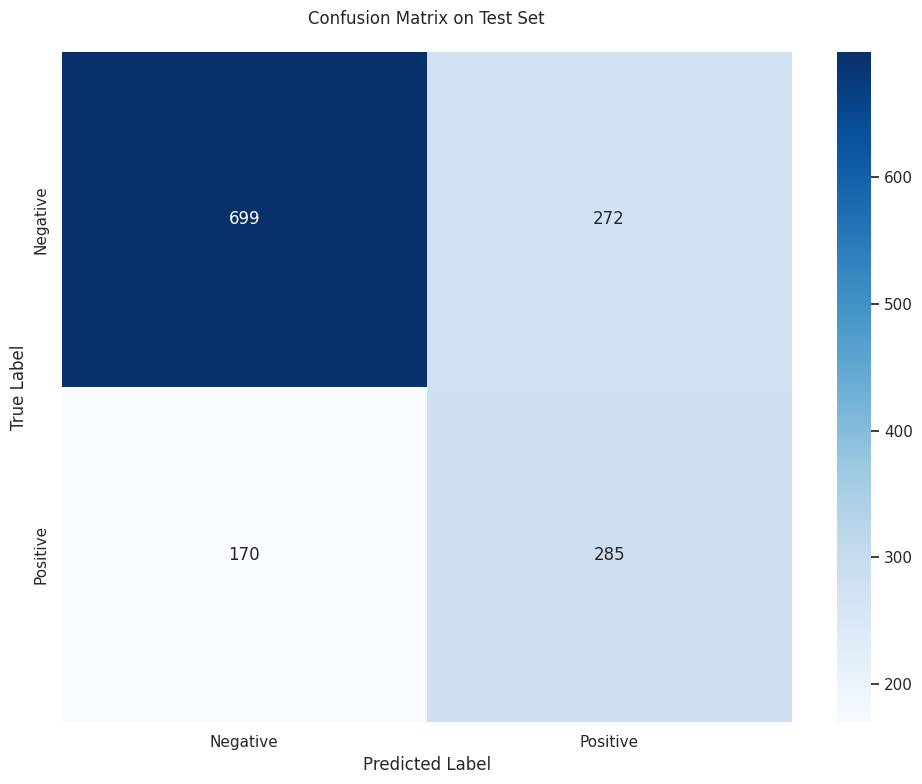

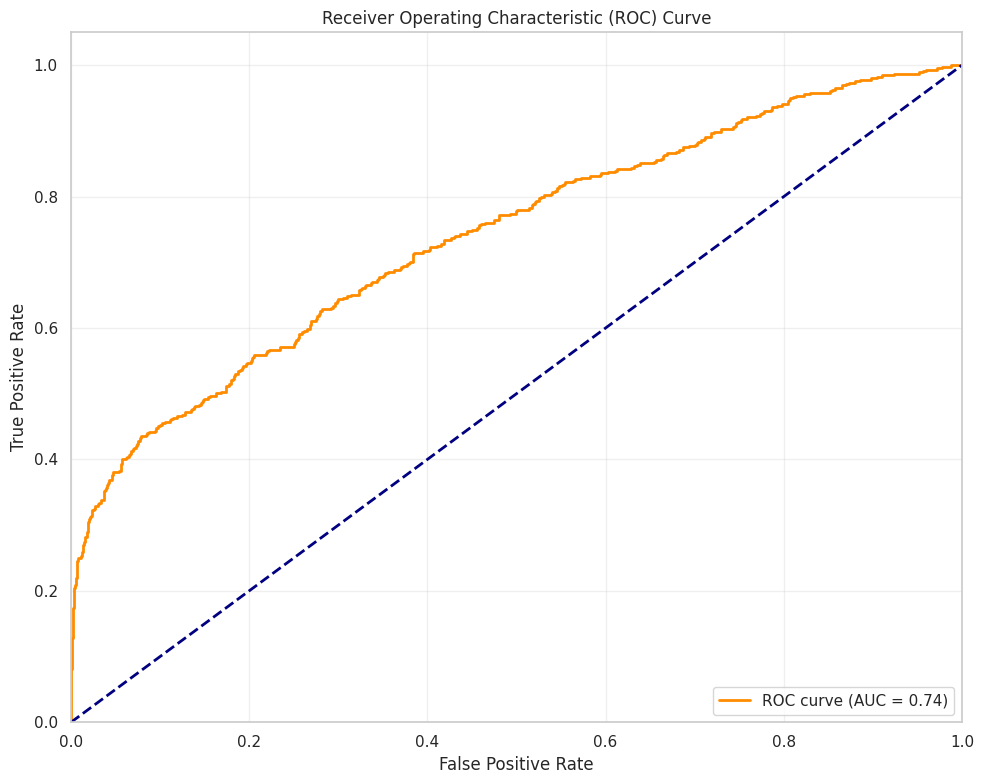

In [22]:
## Test Set Evaluation
import seaborn as sns
import matplotlib.pyplot as plt
print("Evaluating model on test set...")
model.eval()  # Set the model to evaluation mode

# Initialize metrics
test_loss = 0.0
total = 0
correct = 0
test_labels = []
test_predictions = []
test_raw_predictions = []  # For storing raw probabilities

with torch.no_grad():
    for data in test_loader:
        inputs_cc, inputs_mlo, labels = data
        inputs_cc = inputs_cc.float().to(device)
        inputs_mlo = inputs_mlo.float().to(device)
        labels = labels.float().to(device)
        
        labels = labels.unsqueeze(1)
        predicted = model(inputs_cc, inputs_mlo)
        
        # Calculate loss
        loss = criterion(predicted, labels)
        test_loss += loss.item()
        
        # Apply threshold
        thresholded_preds = (predicted > threshold).float()
        
        # Update metrics
        total += labels.size(0)
        correct += (thresholded_preds == labels).sum().item()
        
        # Store predictions and labels for metrics computation
        test_labels.extend(labels.cpu().numpy())
        test_predictions.extend(thresholded_preds.cpu().numpy())
        test_raw_predictions.extend(predicted.cpu().numpy())

# Calculate metrics
test_loss = test_loss / len(test_loader)
test_acc = 100 * correct / total
test_precision = precision_score(test_labels, test_predictions)
test_recall = recall_score(test_labels, test_predictions)
test_f1 = f1_score(test_labels, test_predictions)

# Print results
print("\nTest Set Metrics:")
print(f"  Loss: {test_loss:.5f}")
print(f"  Accuracy: {test_acc:.3f}%")
print(f"  Precision: {test_precision:.3f}")
print(f"  Recall: {test_recall:.3f}")
print(f"  F1 Score: {test_f1:.3f}")

# Calculate confusion matrix
from sklearn.metrics import confusion_matrix

# Create and plot confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid")  # Set seaborn theme
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix on Test Set', pad=20)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ROC curve and AUC score
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(test_labels, test_raw_predictions)
roc_auc = auc(fpr, tpr)

# Set style for ROC curve
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid")  # Reset style for new plot
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Model Evaluation on Test Set
After training, let's evaluate the model's performance on the test set to get unbiased metrics.